# League of Legends Win Prediction with XGBoost

This notebook uses the Kaggle dataset [League of Legends Ranked Matches](https://www.kaggle.com/paololol/league-of-legends-ranked-matches) which contains 180,000 ranked games of League of Legends starting from 2014. Using this data we build an XGBoost model to predict if a player's team will win based on statistics about how that player played the match.

The methods used here are applicable to any dataset. We use this dataset to illustrate how SHAP values help make gradient boosted trees such as XGBoost interpretable. Due to the size, interaction effections, containing both catgoriacl and continuous features and its interpretability (particularly for players of the game) the dataset suits as a good example on various fronts. For more information on SHAP values see: https://github.com/shap/shap 

In [7]:
import time

import matplotlib.pyplot as pl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import xgboost as xgb
from sklearn.model_selection import train_test_split

import shap

shap.initjs()

## Load the dataset

To run this yourself you will need to download the dataset from Kaggle and ensure the `prefix` variable below is correct. To do so follow the link given above and download and extract the data. Change the `prefix` variable if needed.

In [9]:
# read in the
folder_path = "C:\\Users\\azabe\\Downloads\\archive"
matches_file = folder_path + "\\matches.csv"
participants_file = folder_path + "\\participants.csv"
stats1_file = folder_path + "\\stats1.csv"
stats2_file = folder_path + "\\stats2.csv"


matches = pd.read_csv(matches_file)
participants = pd.read_csv(participants_file)
stats1 = pd.read_csv(stats1_file, low_memory=False)
stats2 = pd.read_csv(stats2_file, low_memory=False)
stats = pd.concat([stats1, stats2])

# merge into a single DataFrame
a = pd.merge(
    participants, matches, left_on="id", right_on="id", suffixes=("", "_matches")
)
allstats_orig = pd.merge(a, stats, left_on="id", right_on="id", suffixes=("", "_stats"))
allstats = allstats_orig.copy()

# drop games that lasted less than 10 minutes
allstats = allstats.loc[allstats["duration"] >= 10 * 60, :]

# Convert string-based categories to numeric values
cat_cols = ["role", "position", "version", "platformid"]
for c in cat_cols:
    allstats[c] = allstats[c].astype("category")
    allstats[c] = allstats[c].cat.codes
allstats["wardsbought"] = allstats["wardsbought"].astype(np.int32)

X = allstats.drop(columns=["win"])
y = allstats["win"]

# convert all features we want to consider as rates
rate_features = [
    "kills",
    "deaths",
    "assists",
    "killingsprees",
    "doublekills",
    "triplekills",
    "quadrakills",
    "pentakills",
    "legendarykills",
    "totdmgdealt",
    "magicdmgdealt",
    "physicaldmgdealt",
    "truedmgdealt",
    "totdmgtochamp",
    "magicdmgtochamp",
    "physdmgtochamp",
    "truedmgtochamp",
    "totheal",
    "totunitshealed",
    "dmgtoobj",
    "timecc",
    "totdmgtaken",
    "magicdmgtaken",
    "physdmgtaken",
    "truedmgtaken",
    "goldearned",
    "goldspent",
    "totminionskilled",
    "neutralminionskilled",
    "ownjunglekills",
    "enemyjunglekills",
    "totcctimedealt",
    "pinksbought",
    "wardsbought",
    "wardsplaced",
    "wardskilled",
]
for feature_name in rate_features:
    X[feature_name] /= X["duration"] / 60  # per minute rate

# convert to fraction of game
X["longesttimespentliving"] /= X["duration"]

# define friendly names for the features
full_names = {
    "kills": "Kills per min.",
    "deaths": "Deaths per min.",
    "assists": "Assists per min.",
    "killingsprees": "Killing sprees per min.",
    "longesttimespentliving": "Longest time living as % of game",
    "doublekills": "Double kills per min.",
    "triplekills": "Triple kills per min.",
    "quadrakills": "Quadra kills per min.",
    "pentakills": "Penta kills per min.",
    "legendarykills": "Legendary kills per min.",
    "totdmgdealt": "Total damage dealt per min.",
    "magicdmgdealt": "Magic damage dealt per min.",
    "physicaldmgdealt": "Physical damage dealt per min.",
    "truedmgdealt": "True damage dealt per min.",
    "totdmgtochamp": "Total damage to champions per min.",
    "magicdmgtochamp": "Magic damage to champions per min.",
    "physdmgtochamp": "Physical damage to champions per min.",
    "truedmgtochamp": "True damage to champions per min.",
    "totheal": "Total healing per min.",
    "totunitshealed": "Total units healed per min.",
    "dmgtoobj": "Damage to objects per min.",
    "timecc": "Time spent with crown control per min.",
    "totdmgtaken": "Total damage taken per min.",
    "magicdmgtaken": "Magic damage taken per min.",
    "physdmgtaken": "Physical damage taken per min.",
    "truedmgtaken": "True damage taken per min.",
    "goldearned": "Gold earned per min.",
    "goldspent": "Gold spent per min.",
    "totminionskilled": "Total minions killed per min.",
    "neutralminionskilled": "Neutral minions killed per min.",
    "ownjunglekills": "Own jungle kills per min.",
    "enemyjunglekills": "Enemy jungle kills per min.",
    "totcctimedealt": "Total crown control time dealt per min.",
    "pinksbought": "Pink wards bought per min.",
    "wardsbought": "Wards bought per min.",
    "wardsplaced": "Wards placed per min.",
    "turretkills": "# of turret kills",
    "inhibkills": "# of inhibitor kills",
    "dmgtoturrets": "Damage to turrets",
}
feature_names = [full_names.get(n, n) for n in X.columns]
X.columns = feature_names

# create train/validation split
Xt, Xv, yt, yv = train_test_split(X, y, test_size=0.2, random_state=10)
dt = xgb.DMatrix(Xt, label=yt.values)
dv = xgb.DMatrix(Xv, label=yv.values)

## Train the XGBoost model

In [11]:
params = {
    "objective": "binary:logistic",
    "base_score": np.mean(yt),
    "eval_metric": "logloss",
}
model = xgb.train(
    params,
    dt,
    num_boost_round=10,
    evals=[(dt, "train"), (dv, "valid")],
    early_stopping_rounds=5,
    verbose_eval=25,
)

[0]	train-logloss:0.57211	valid-logloss:0.57507
[9]	train-logloss:0.34310	valid-logloss:0.35730


## Train the MLP model

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

# Define columns to be dropped
id_columns = ["id", "matchid", "gameid", "platformid"]
feature_names_ = [name for name in feature_names if name not in id_columns]
# Feature scaling
scaler = StandardScaler()
Xt_scaled = scaler.fit_transform(Xt.drop(columns=id_columns))
Xv_scaled = scaler.transform(Xv.drop(columns=id_columns))

# Convert scaled data to PyTorch tensors
Xt_tensor = torch.tensor(Xt_scaled, dtype=torch.float32)
yt_tensor = torch.tensor(yt.values, dtype=torch.float32)
Xv_tensor = torch.tensor(Xv_scaled, dtype=torch.float32)
yv_tensor = torch.tensor(yv.values, dtype=torch.float32)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(Xt_tensor, yt_tensor)
valid_dataset = TensorDataset(Xv_tensor, yv_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False)


# Define a simple neural network model
class SimpleNN(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.sigmoid(self.layer3(x))
        return x


# Get the input dimension
input_dim = Xt_scaled.shape[1]

# Instantiate the model with the correct input dimension
model_nn = SimpleNN(input_dim)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model_nn.parameters(), lr=0.001)  # Adjusted learning rate

# Training loop
num_epochs = 20
best_loss = float("inf")

for epoch in range(num_epochs):
    model_nn.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model_nn(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader)

    model_nn.eval()
    valid_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            outputs = model_nn(X_batch).squeeze()
            loss = criterion(outputs, y_batch)
            valid_loss += loss.item()

    valid_loss /= len(valid_loader)

    print(
        f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}"
    )

    # Early stopping
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model_nn.state_dict(), "best_model.pth")

Epoch 1/20, Train Loss: 0.3085, Valid Loss: 0.2768
Epoch 2/20, Train Loss: 0.2647, Valid Loss: 0.2647
Epoch 3/20, Train Loss: 0.2508, Valid Loss: 0.2534
Epoch 4/20, Train Loss: 0.2434, Valid Loss: 0.2491
Epoch 5/20, Train Loss: 0.2381, Valid Loss: 0.2479
Epoch 6/20, Train Loss: 0.2339, Valid Loss: 0.2447
Epoch 7/20, Train Loss: 0.2313, Valid Loss: 0.2443
Epoch 8/20, Train Loss: 0.2279, Valid Loss: 0.2419
Epoch 9/20, Train Loss: 0.2251, Valid Loss: 0.2448
Epoch 10/20, Train Loss: 0.2225, Valid Loss: 0.2460
Epoch 11/20, Train Loss: 0.2201, Valid Loss: 0.2424
Epoch 12/20, Train Loss: 0.2168, Valid Loss: 0.2461
Epoch 13/20, Train Loss: 0.2152, Valid Loss: 0.2408
Epoch 14/20, Train Loss: 0.2127, Valid Loss: 0.2418
Epoch 15/20, Train Loss: 0.2108, Valid Loss: 0.2416
Epoch 16/20, Train Loss: 0.2087, Valid Loss: 0.2456
Epoch 17/20, Train Loss: 0.2073, Valid Loss: 0.2456
Epoch 18/20, Train Loss: 0.2047, Valid Loss: 0.2491
Epoch 19/20, Train Loss: 0.2033, Valid Loss: 0.2454
Epoch 20/20, Train Lo

In [15]:
# Load the best model
model_nn.load_state_dict(torch.load("best_model.pth"))
model_nn.eval()

# Making predictions on the validation set
with torch.no_grad():
    yv_preds = model_nn(Xv_tensor).squeeze()
    yv_preds = yv_preds.numpy()

# Binarize the predictions based on a threshold of 0.5
yv_preds_binary = (yv_preds > 0.5).astype(int)

# Print out a few predictions and their corresponding true values
print("Predictions:", yv_preds_binary[:10])
print("True values:", yv_tensor.numpy()[:10])

Predictions: [0 0 0 0 0 0 1 1 1 1]
True values: [0. 0. 0. 1. 0. 0. 1. 1. 1. 1.]


In [16]:
def predict_nn(data):
    # Convert the input data to a PyTorch tensor
    data_tensor = torch.tensor(data, dtype=torch.float32)
    model_nn.eval()
    with torch.no_grad():
        # Get the model's predictions
        predictions = model_nn(data_tensor).squeeze().numpy()
    return predictions

## Explain the XGBoost model

Because the Tree SHAP algorithm is implemented in XGBoost we can compute exact SHAP values quickly over thousands of samples. The SHAP values for a single prediction (including the expected output in the last column) sum to the model's output for that prediction.

In [23]:
# compute the SHAP values for every prediction in the validation dataset
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Xv)

Predictions shape: (100,)
Predictions shape: (100,)
Predictions shape: (200,)
Predictions shape: (400,)
Predictions shape: (800,)
Predictions shape: (1000,)
Predictions shape: (1000,)
Predictions shape: (1000,)
Predictions shape: (1000,)
Predictions shape: (1000,)
Predictions shape: (1000,)
Predictions shape: (1000,)
Predictions shape: (1000,)
Predictions shape: (1000,)
Predictions shape: (1000,)
Predictions shape: (1000,)
Predictions shape: (1000,)
Predictions shape: (1000,)
Predictions shape: (1000,)
Predictions shape: (1000,)
Predictions shape: (1000,)
Predictions shape: (1000,)
Predictions shape: (1000,)
Predictions shape: (1000,)
Predictions shape: (1000,)
Predictions shape: (1000,)
Predictions shape: (1000,)
Predictions shape: (1000,)
Predictions shape: (1000,)
Predictions shape: (1000,)
Predictions shape: (1000,)
Predictions shape: (1000,)
Predictions shape: (1000,)
Predictions shape: (1000,)
Predictions shape: (1000,)
Predictions shape: (1000,)
Predictions shape: (1000,)
Predic

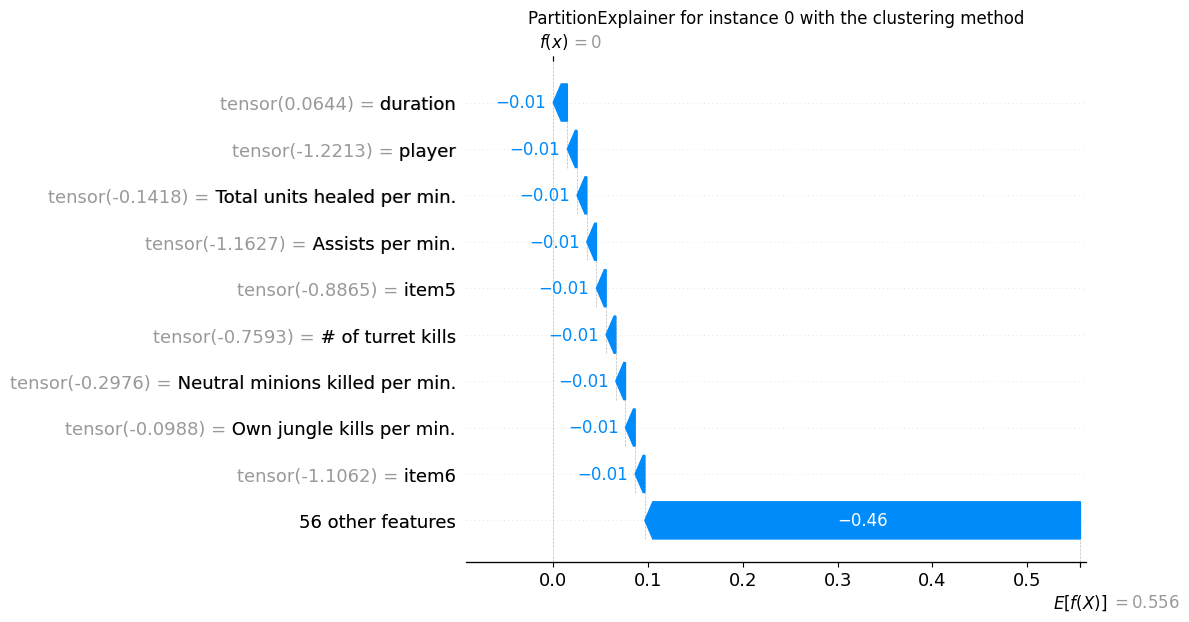

In [172]:
partition_masker = shap.maskers.Partition(Xt_scaled)
clustering_explainer = shap.PartitionExplainer(
    predict_nn, partition_masker, feature_names=feature_names_
)

# Select an instance to explain (e.g., the first instance from the validation set)
instance_nn = Xv_tensor[0:20]

# Compute the SHAP values for the selected instance
clustering_shap_values_nn = clustering_explainer(instance_nn)

# Print the last evaluation count
print(clustering_explainer.last_eval_count)

fig, ax = plt.subplots()
shap.plots.waterfall(clustering_shap_values_nn[0], show=False)
plt.title("PartitionExplainer for instance 0 with the clustering method")
plt.show()

In [173]:
shap.force_plot(
    clustering_shap_values_nn.base_values,
    clustering_shap_values_nn.values,
    Xv_tensor[0:20].numpy(),
    feature_names=feature_names_,
)

<Figure size 1500x600 with 0 Axes>

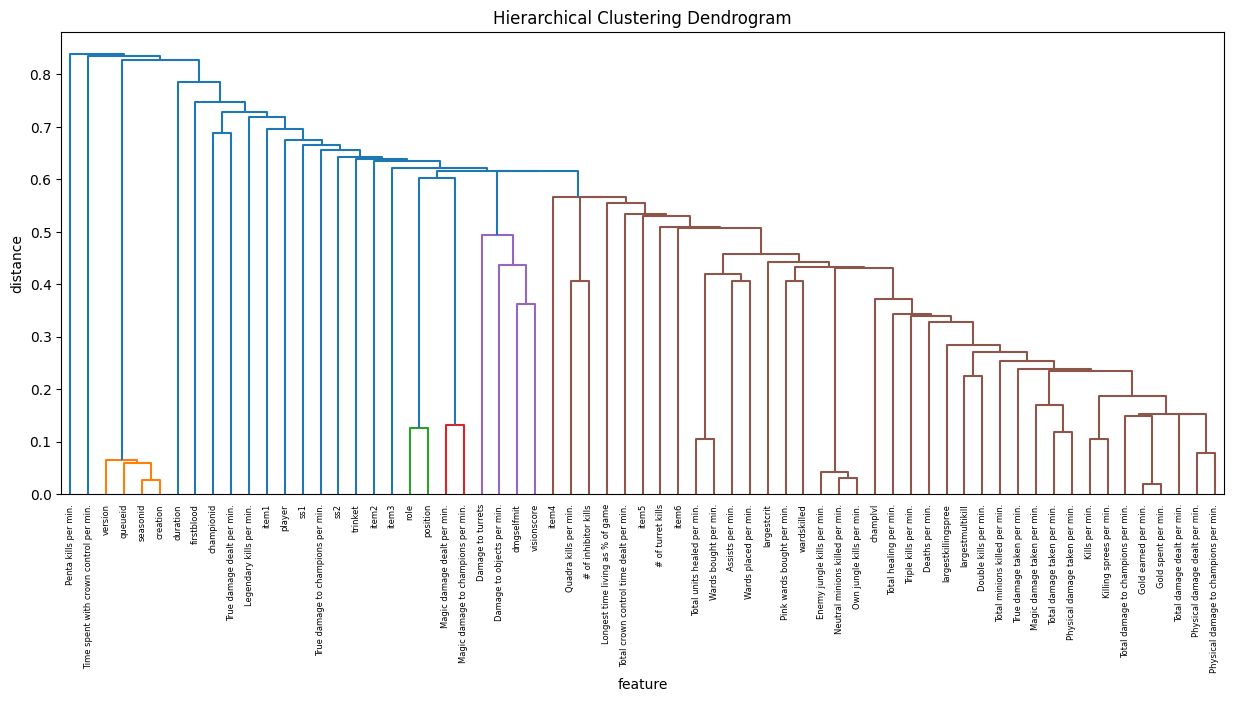

In [176]:
plt.figure(figsize=(15, 6))
sp.cluster.hierarchy.dendrogram(clustering_explainer._clustering, labels=feature_names_)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("feature")
plt.ylabel("distance")
plt.show()

498


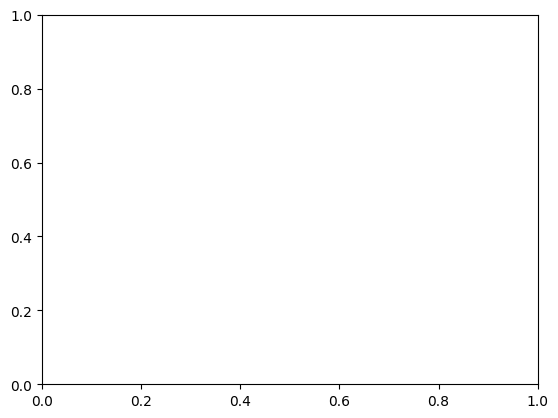

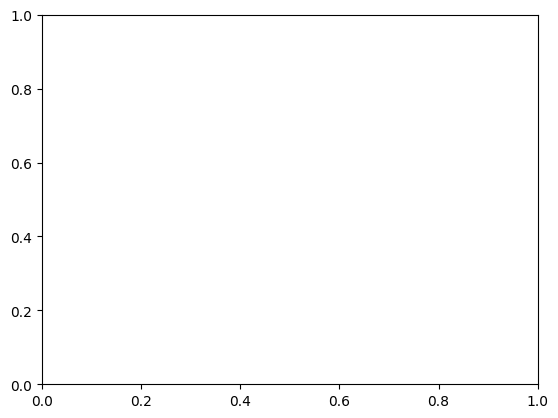

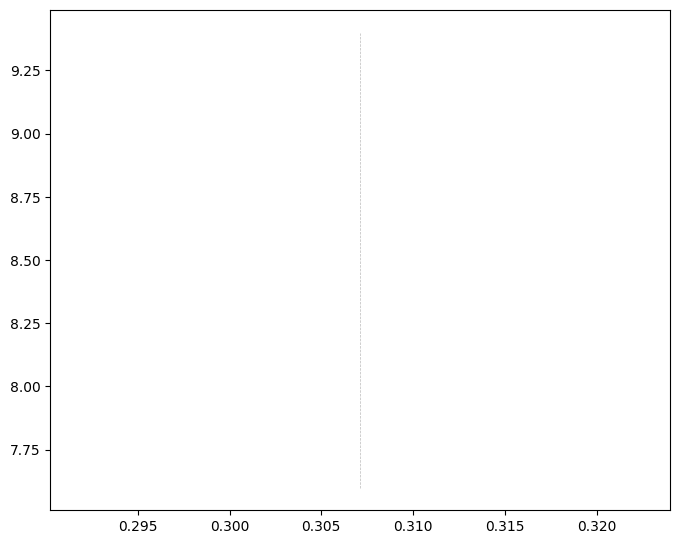

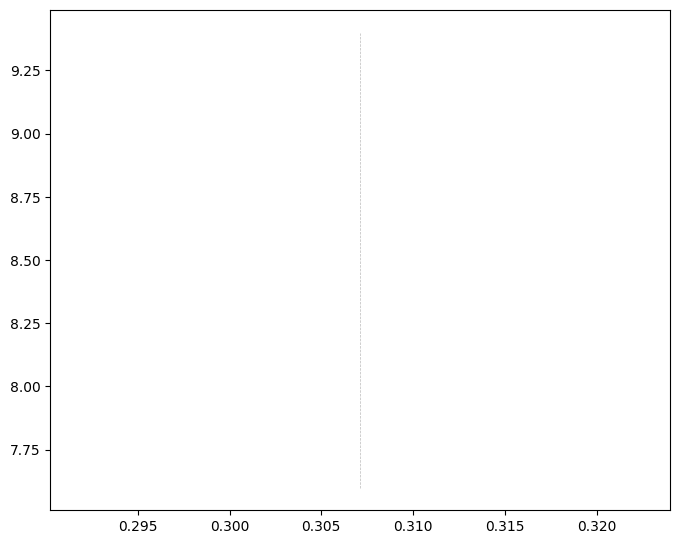

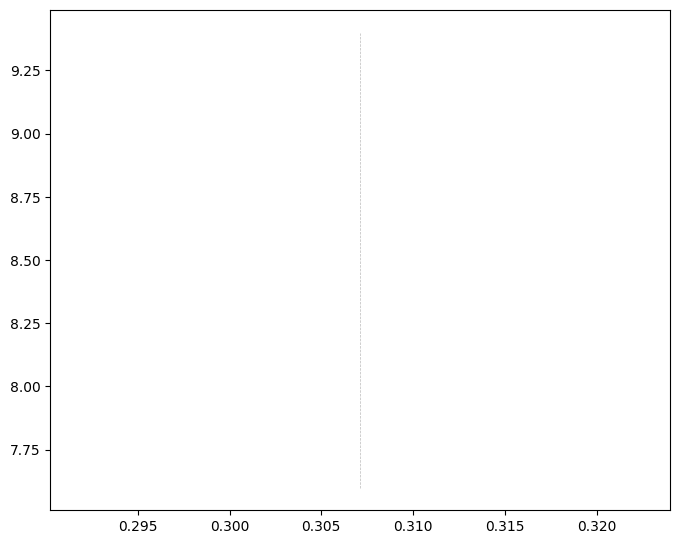

<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

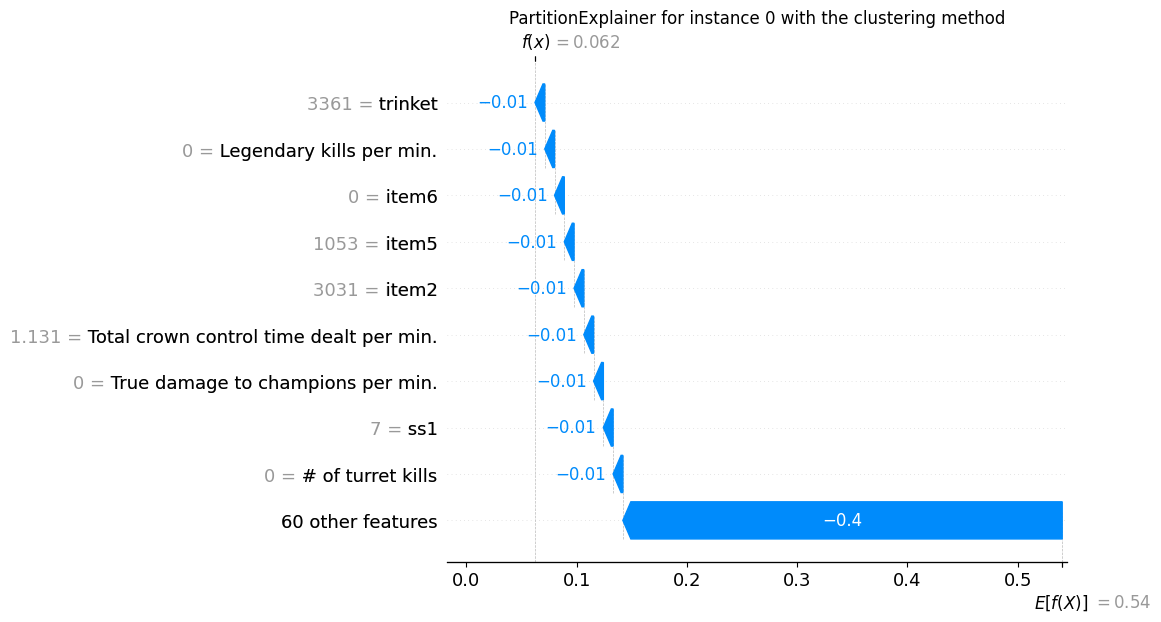

In [168]:
def predict(data):
    dmatrix = xgb.DMatrix(data, feature_names=list(Xt.columns))
    return model.predict(dmatrix)


partition_masker = shap.maskers.Partition(Xt)
clustering_explainer = shap.PartitionExplainer(
    predict, partition_masker, feature_names=feature_names_
)


instance = Xv.iloc[0:20, :]
# Compute the SHAP values for the selected instance
clustering_shap_values_xgb = clustering_explainer(instance)

# Print the last evaluation count
print(clustering_explainer.last_eval_count)

fig, ax = plt.subplots()
shap.plots.waterfall(clustering_shap_values_xgb[0], show=False)
plt.title("PartitionExplainer for instance 0 with the clustering method")
plt.show()

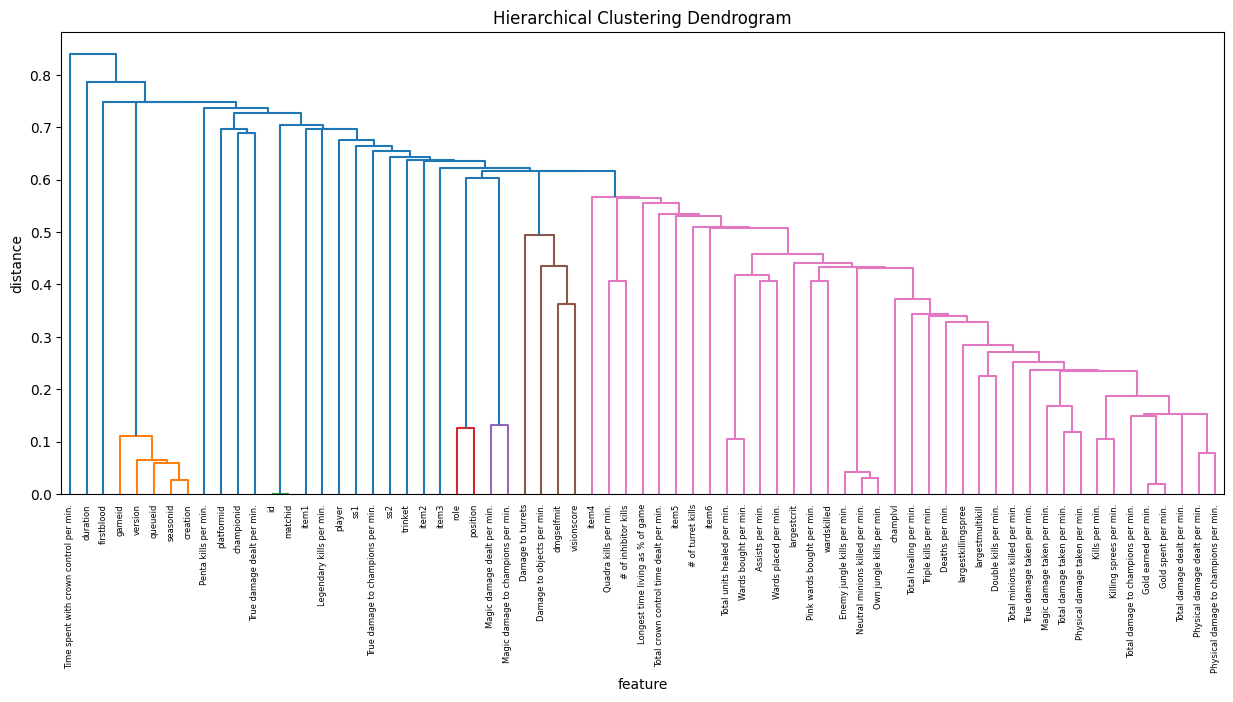

In [169]:
plt.figure(figsize=(15, 6))
sp.cluster.hierarchy.dendrogram(
    clustering_explainer._clustering, labels=list(Xt.columns)
)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("feature")
plt.ylabel("distance")
plt.show()

In [59]:
shap.force_plot(
    clustering_shap_values_xgb.base_values,
    clustering_shap_values_xgb.values,
    Xv.iloc[0:20, :],
)

In [104]:
kernel_explainer = shap.KernelExplainer(predict, Xt.iloc[:100, :])
shap_values_kernel = kernel_explainer.shap_values(instance, nsamples=500)

shap.force_plot(kernel_explainer.expected_value, shap_values_kernel, instance)

  0%|          | 0/20 [00:00<?, ?it/s]

In [122]:
def predict_nn(data):
    # Convert the input data to a PyTorch tensor
    data_tensor = torch.tensor(data, dtype=torch.float32)
    model_nn.eval()
    with torch.no_grad():
        # Get the model's predictions
        predictions = model_nn(data_tensor).squeeze().numpy()
        # Ensure the predictions are a 1-dimensional array
        if predictions.ndim == 0:
            predictions = np.array([predictions])
        print(f"Predictions shape: {predictions.shape}")
    return predictions


kernel_explainer = shap.KernelExplainer(predict_nn, Xt_scaled[:100, :])
shap_values_kernel2 = kernel_explainer.shap_values(np.array(instance_nn), nsamples=500)

Predictions shape: (100,)


  0%|          | 0/20 [00:00<?, ?it/s]

Predictions shape: (1,)
Predictions shape: (50000,)
Predictions shape: (1,)
Predictions shape: (50000,)
Predictions shape: (1,)
Predictions shape: (50000,)
Predictions shape: (1,)
Predictions shape: (50000,)
Predictions shape: (1,)
Predictions shape: (50000,)
Predictions shape: (1,)
Predictions shape: (50000,)
Predictions shape: (1,)
Predictions shape: (50000,)
Predictions shape: (1,)
Predictions shape: (50000,)
Predictions shape: (1,)
Predictions shape: (50000,)
Predictions shape: (1,)
Predictions shape: (50000,)
Predictions shape: (1,)
Predictions shape: (50000,)
Predictions shape: (1,)
Predictions shape: (50000,)
Predictions shape: (1,)
Predictions shape: (50000,)
Predictions shape: (1,)
Predictions shape: (50000,)
Predictions shape: (1,)
Predictions shape: (50000,)
Predictions shape: (1,)
Predictions shape: (50000,)
Predictions shape: (1,)
Predictions shape: (50000,)
Predictions shape: (1,)
Predictions shape: (50000,)
Predictions shape: (1,)
Predictions shape: (50000,)
Predictions 

In [123]:
shap.force_plot(
    kernel_explainer.expected_value,
    shap_values_kernel2,
    np.array(instance_nn),
    feature_names=feature_names_,
)

In [17]:
partition_tree_nn = {
    "Identifiers": {
        "PlayerIdentifiers": {
            "player": "player",
            "championid": "championid",
            "role": "role",
            "position": "position",
        },
        "Versioning": {
            "version": "version",
            "queueid": "queueid",
            "seasonid": "seasonid",
        },
    },
    "GameDetails": {
        "Timing": {"duration": "duration", "creation": "creation"},
        "Spells": {"ss1": "ss1", "ss2": "ss2"},
    },
    "Items": {
        "MainItems": {
            "item1": "item1",
            "item2": "item2",
            "item3": "item3",
            "item4": "item4",
            "item5": "item5",
            "item6": "item6",
        },
        "Trinkets": {"trinket": "trinket"},
    },
    "CombatStats": {
        "Kills": {
            "TotalKills": {
                "Kills per min.": "Kills per min.",
                "largestkillingspree": "largestkillingspree",
                "largestmultikill": "largestmultikill",
                "Killing sprees per min.": "Killing sprees per min.",
            },
            "SpecialKills": {
                "Double kills per min.": "Double kills per min.",
                "Triple kills per min.": "Triple kills per min.",
                "Quadra kills per min.": "Quadra kills per min.",
                "Penta kills per min.": "Penta kills per min.",
                "Legendary kills per min.": "Legendary kills per min.",
            },
        },
        "DamageDealt": {
            "TotalDamageDealt": {
                "Total damage dealt per min.": "Total damage dealt per min.",
                "largestcrit": "largestcrit",
            },
            "DamageTypesDealt": {
                "Magic damage dealt per min.": "Magic damage dealt per min.",
                "Physical damage dealt per min.": "Physical damage dealt per min.",
                "True damage dealt per min.": "True damage dealt per min.",
            },
        },
        "DamageToChampions": {
            "TotalDamageToChampions": {
                "Total damage to champions per min.": "Total damage to champions per min."
            },
            "DamageTypesToChampions": {
                "Magic damage to champions per min.": "Magic damage to champions per min.",
                "Physical damage to champions per min.": "Physical damage to champions per min.",
                "True damage to champions per min.": "True damage to champions per min.",
            },
        },
        "Healing": {
            "TotalHealing": {
                "Total healing per min.": "Total healing per min.",
                "Total units healed per min.": "Total units healed per min.",
            }
        },
        "DamageTaken": {
            "TotalDamageTaken": {
                "Total damage taken per min.": "Total damage taken per min."
            },
            "DamageTypesTaken": {
                "Magic damage taken per min.": "Magic damage taken per min.",
                "Physical damage taken per min.": "Physical damage taken per min.",
                "True damage taken per min.": "True damage taken per min.",
            },
        },
        "CrowdControl": {
            "CrowdControlTimes": {
                "Time spent with crown control per min.": "Time spent with crown control per min.",
                "Total crown control time dealt per min.": "Total crown control time dealt per min.",
            }
        },
    },
    "Objectives": {
        "DamageToObjectives": {
            "DamageToObjects": {
                "Damage to objects per min.": "Damage to objects per min."
            },
            "DamageToTurrets": {"Damage to turrets": "Damage to turrets"},
        },
        "Kills": {
            "TurretKills": {"# of turret kills": "# of turret kills"},
            "InhibitorKills": {"# of inhibitor kills": "# of inhibitor kills"},
        },
    },
    "Economy": {
        "Gold": {
            "GoldEarned": {"Gold earned per min.": "Gold earned per min."},
            "GoldSpent": {"Gold spent per min.": "Gold spent per min."},
        },
        "Wards": {
            "PinkWards": {"Pink wards bought per min.": "Pink wards bought per min."},
            "OtherWards": {
                "Wards bought per min.": "Wards bought per min.",
                "Wards placed per min.": "Wards placed per min.",
                "wardskilled": "wardskilled",
            },
        },
    },
    "Minions": {
        "TotalMinionsKilled": {
            "Total minions killed per min.": "Total minions killed per min."
        },
        "NeutralMinionsKilled": {
            "Neutral minions killed per min.": "Neutral minions killed per min.",
            "Own jungle kills per min.": "Own jungle kills per min.",
            "Enemy jungle kills per min.": "Enemy jungle kills per min.",
        },
    },
    "Miscellaneous": {
        "LongestTimeLiving": {
            "Longest time living as % of game": "Longest time living as % of game"
        },
        "VisionScore": {"visionscore": "visionscore"},
        "ChampionLevel": {"champlvl": "champlvl"},
        "FirstBlood": {"firstblood": "firstblood"},
        "SelfMitigation": {"dmgselfmit": "dmgselfmit"},
    },
}
partition_tree = {
    "Identifiers": {
        "MatchIdentifiers": {
            "id": "id",
            "matchid": "matchid",
            "gameid": "gameid",
            "platformid": "platformid",
        },
        "PlayerIdentifiers": {
            "player": "player",
            "championid": "championid",
            "role": "role",
            "position": "position",
        },
        "Versioning": {
            "version": "version",
            "queueid": "queueid",
            "seasonid": "seasonid",
        },
    },
    "GameDetails": {
        "Timing": {"duration": "duration", "creation": "creation"},
        "Spells": {"ss1": "ss1", "ss2": "ss2"},
    },
    "Items": {
        "MainItems": {
            "item1": "item1",
            "item2": "item2",
            "item3": "item3",
            "item4": "item4",
            "item5": "item5",
            "item6": "item6",
        },
        "Trinkets": {"trinket": "trinket"},
    },
    "CombatStats": {
        "Kills": {
            "TotalKills": {
                "Kills per min.": "Kills per min.",
                "largestkillingspree": "largestkillingspree",
                "largestmultikill": "largestmultikill",
                "Killing sprees per min.": "Killing sprees per min.",
            },
            "SpecialKills": {
                "Double kills per min.": "Double kills per min.",
                "Triple kills per min.": "Triple kills per min.",
                "Quadra kills per min.": "Quadra kills per min.",
                "Penta kills per min.": "Penta kills per min.",
                "Legendary kills per min.": "Legendary kills per min.",
            },
        },
        "DamageDealt": {
            "TotalDamageDealt": {
                "Total damage dealt per min.": "Total damage dealt per min.",
                "largestcrit": "largestcrit",
            },
            "DamageTypesDealt": {
                "Magic damage dealt per min.": "Magic damage dealt per min.",
                "Physical damage dealt per min.": "Physical damage dealt per min.",
                "True damage dealt per min.": "True damage dealt per min.",
            },
        },
        "DamageToChampions": {
            "TotalDamageToChampions": {
                "Total damage to champions per min.": "Total damage to champions per min."
            },
            "DamageTypesToChampions": {
                "Magic damage to champions per min.": "Magic damage to champions per min.",
                "Physical damage to champions per min.": "Physical damage to champions per min.",
                "True damage to champions per min.": "True damage to champions per min.",
            },
        },
        "Healing": {
            "TotalHealing": {
                "Total healing per min.": "Total healing per min.",
                "Total units healed per min.": "Total units healed per min.",
            }
        },
        "DamageTaken": {
            "TotalDamageTaken": {
                "Total damage taken per min.": "Total damage taken per min."
            },
            "DamageTypesTaken": {
                "Magic damage taken per min.": "Magic damage taken per min.",
                "Physical damage taken per min.": "Physical damage taken per min.",
                "True damage taken per min.": "True damage taken per min.",
            },
        },
        "CrowdControl": {
            "CrowdControlTimes": {
                "Time spent with crown control per min.": "Time spent with crown control per min.",
                "Total crown control time dealt per min.": "Total crown control time dealt per min.",
            }
        },
    },
    "Objectives": {
        "DamageToObjectives": {
            "DamageToObjects": {
                "Damage to objects per min.": "Damage to objects per min."
            },
            "DamageToTurrets": {"Damage to turrets": "Damage to turrets"},
        },
        "Kills": {
            "TurretKills": {"# of turret kills": "# of turret kills"},
            "InhibitorKills": {"# of inhibitor kills": "# of inhibitor kills"},
        },
    },
    "Economy": {
        "Gold": {
            "GoldEarned": {"Gold earned per min.": "Gold earned per min."},
            "GoldSpent": {"Gold spent per min.": "Gold spent per min."},
        },
        "Wards": {
            "PinkWards": {"Pink wards bought per min.": "Pink wards bought per min."},
            "OtherWards": {
                "Wards bought per min.": "Wards bought per min.",
                "Wards placed per min.": "Wards placed per min.",
                "wardskilled": "wardskilled",
            },
        },
    },
    "Minions": {
        "TotalMinionsKilled": {
            "Total minions killed per min.": "Total minions killed per min."
        },
        "NeutralMinionsKilled": {
            "Neutral minions killed per min.": "Neutral minions killed per min.",
            "Own jungle kills per min.": "Own jungle kills per min.",
            "Enemy jungle kills per min.": "Enemy jungle kills per min.",
        },
    },
    "Miscellaneous": {
        "LongestTimeLiving": {
            "Longest time living as % of game": "Longest time living as % of game"
        },
        "VisionScore": {"visionscore": "visionscore"},
        "ChampionLevel": {"champlvl": "champlvl"},
        "FirstBlood": {"firstblood": "firstblood"},
        "SelfMitigation": {"dmgselfmit": "dmgselfmit"},
    },
}


def predict(data):
    dmatrix = xgb.DMatrix(data, feature_names=list(Xt.columns))
    return model.predict(dmatrix)


instance = Xv.iloc[0:1, :]

print(instance)

          id  matchid  player  championid  ss1  ss2  role  position  \
11267  13910     1400       2         222    7    4     1         0   

           gameid  platformid  ...  Neutral minions killed per min.  \
11267  3183934474           1  ...                          0.34555   

       Own jungle kills per min.  Enemy jungle kills per min.  \
11267                    0.34555                          0.0   

       Total crown control time dealt per min.  champlvl  \
11267                                  1.13089        14   

       Pink wards bought per min.  Wards bought per min.  \
11267                         0.0                    0.0   

       Wards placed per min.  wardskilled  firstblood  
11267               0.062827          0.0           0  

[1 rows x 69 columns]


498


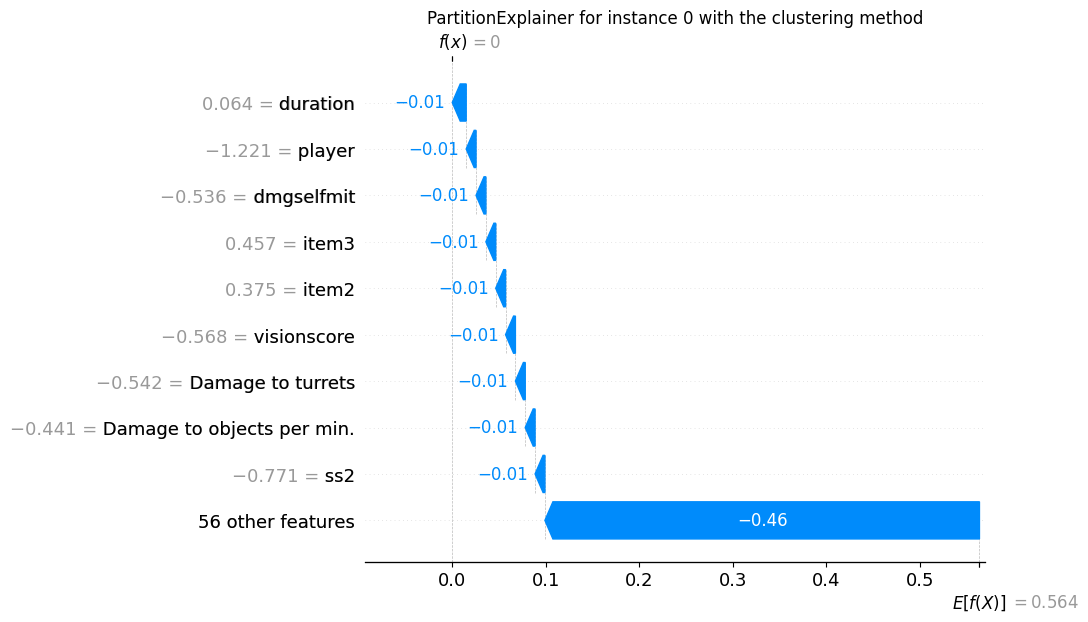

In [18]:
partition_masker = shap.maskers.Partition(Xt_scaled)
clustering_explainer = shap.PartitionExplainer(
    predict_nn, partition_masker, feature_names=feature_names_
)

# Select an instance to explain (e.g., the first instance from the validation set)
instance_nn = Xv_tensor[0:1].numpy()

# Compute the SHAP values for the selected instance
clustering_shap_values = clustering_explainer(instance_nn)

# Print the last evaluation count
print(clustering_explainer.last_eval_count)

fig, ax = plt.subplots()
shap.plots.waterfall(clustering_shap_values[0], show=False)
plt.title("PartitionExplainer for instance 0 with the clustering method")
plt.show()

In [19]:
Xt_scaled

array([[ 0.17239304, -0.85377246,  1.39079982, ..., -0.23451413,
         0.4373733 , -0.33016523],
       [ 1.21765636, -0.50905595, -0.63333241, ..., -0.25343425,
         0.53507816, -0.33016523],
       [-0.87287028, -0.08478946, -0.63333241, ...,  1.79860322,
         2.55433792, -0.33016523],
       ...,
       [ 0.52081414, -0.80957804,  0.12571718, ..., -1.26443943,
        -0.75637959, -0.33016523],
       [ 1.21765636, -0.62396145, -0.88634894, ..., -0.71653988,
         0.08921246, -0.33016523],
       [ 1.21765636, -0.30576159,  1.13778329, ..., -0.08753802,
        -0.37651563, -0.33016523]])

In [20]:
Xv_tensor[0:1].numpy().reshape(1, -1).shape

(1, 65)

In [21]:
Xv_tensor[0:1].numpy().shape

(1, 65)

In [22]:
Xv_tensor[0:10].shape

torch.Size([10, 65])

PartitionExplainer explainer: 2it [03:15, 195.83s/it]              


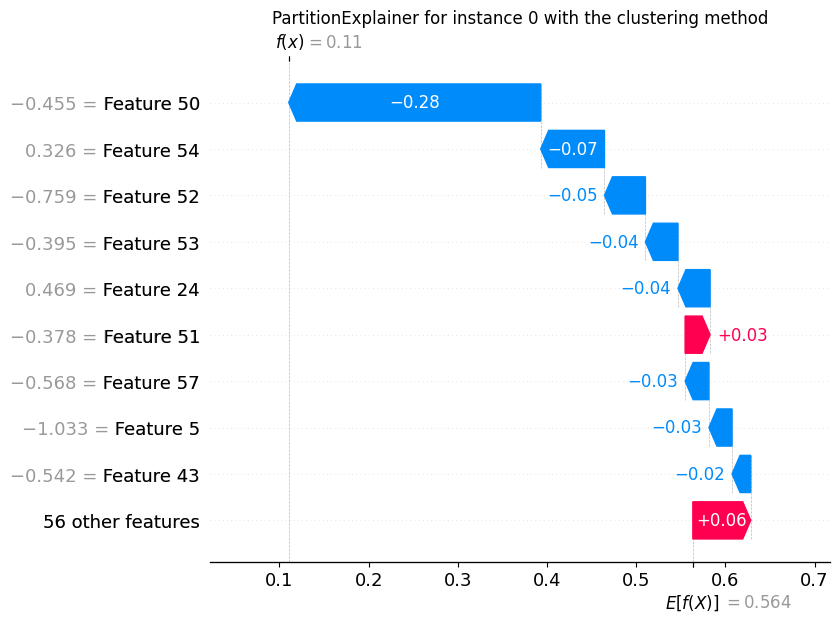

In [23]:
Xt_scaled_df = pd.DataFrame(Xt_scaled, columns=feature_names_)
partition_masker = shap.maskers.Partition(Xt_scaled_df)
partition_explainer_nn = shap.PartitionExplainer(
    predict_nn, partition_masker, partition_tree=partition_tree_nn
)

# Select an instance to explain (e.g., the first instance from the validation set)
instance_nn = Xv_tensor[0:1].numpy()

# Compute the SHAP values for the selected instance
partition_shap_values = partition_explainer_nn(instance_nn)

# Print the last evaluation count

fig, ax = plt.subplots()
shap.plots.waterfall(partition_shap_values[0], show=False)
plt.title("PartitionExplainer for instance 0 with the clustering method")
plt.show()

In [24]:
references = Xv_tensor[0:20].numpy()

# Compute the SHAP values for the selected instance
partition_shap_values2 = partition_explainer_nn(references)

PartitionExplainer explainer: 21it [1:30:55, 272.76s/it]                        


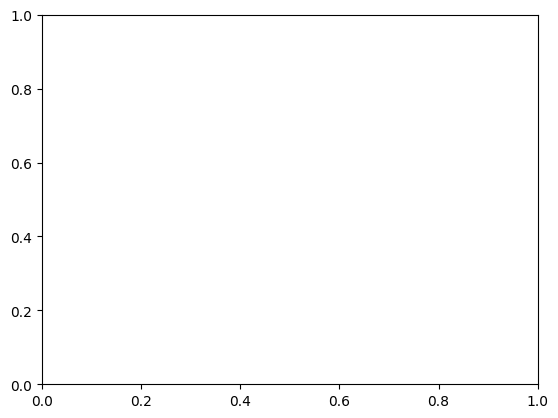

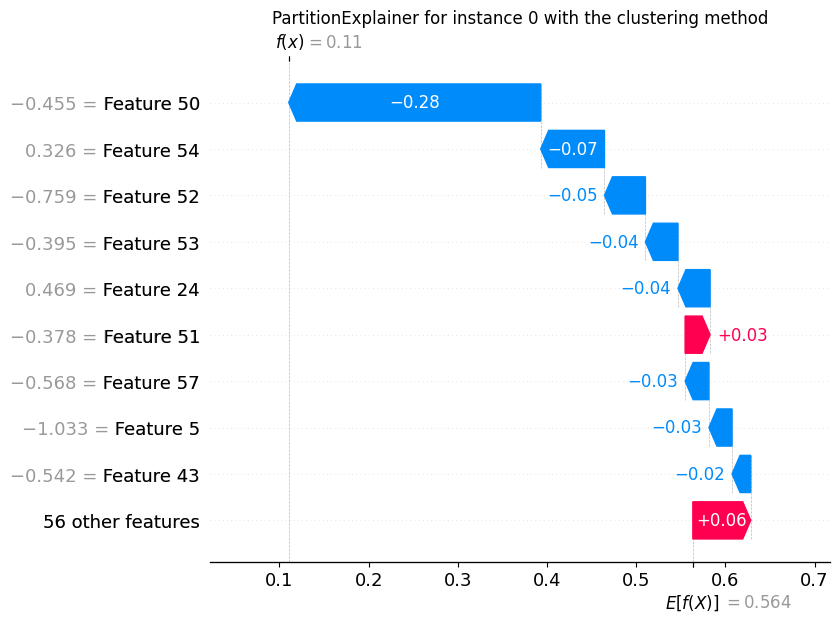

In [65]:
fig, ax = plt.subplots()
shap.plots.waterfall(partition_shap_values[0], show=False)
plt.title("PartitionExplainer for instance 0 with the clustering method")
plt.show()

In [67]:
kernel_explainer = shap.KernelExplainer(predict, Xt.iloc[:50, :])
shap_values_kernel = kernel_explainer.shap_values(instance, nsamples=500)

shap.force_plot(kernel_explainer.expected_value, shap_values_kernel, instance)

  0%|          | 0/1 [00:00<?, ?it/s]

In [69]:
partition_masker = shap.maskers.Partition(Xt_scaled)
partition_explainer = shap.PartitionExplainer(
    predict_nn,
    partition_masker,
    partition_tree=partition_tree,
    feature_names=feature_names_,
)

In [71]:
instance_ = Xv_tensor[0].numpy().reshape(1, -1)

# Compute the SHAP values for the selected instance
# partition_shap_values = partition_explainer(instance)

In [73]:
# fig, ax = plt.subplots()
# shap.plots.waterfall(partition_shap_values[0], show=False)
# plt.title("PartitionExplainer for instance 0 with the clustering method")
# plt.show()

In [76]:
partition_masker = shap.maskers.Partition(Xt)

partition_explainer = shap.PartitionExplainer(
    predict, partition_masker, partition_tree=partition_tree
)
start_time = time.time()
winter_values = partition_explainer(instance)
custom_partition_time = time.time() - start_time
print(custom_partition_time)

PartitionExplainer explainer: 2it [07:43, 463.89s/it]              

463.888236284256


In [77]:
winter_values[0]

.values =
array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -7.04311579e-05,
        0.00000000e+00,  0.00000000e+00, -2.64469412e-02, -3.65690713e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        8.44014805e-04,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.30376378e-04,
        5.10734181e-04,  0.00000000e+00,  9.67485522e-03,  0.00000000e+00,
        0.00000000e+00, -2.65848574e-03,  0.00000000e+00, -1.68103298e-03,
       -2.62107078e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  3.04248220e-03,  0.00000000e+00,
       -1.24962191e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -6.77992859e-05,  2.07804608e-02, -2.03540870e-03, -4.19213260e-02,
        0.00000000e+00,  0.00000000e+00,  8.96064072e-03,  1.84162414e-03,
        0.00000

In [78]:
winter_values.base_values

array([0.54039099])

In [79]:
winter_values.values.shape

(1, 69)

In [80]:
winter_values.values[0]

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -7.04311579e-05,
        0.00000000e+00,  0.00000000e+00, -2.64469412e-02, -3.65690713e-03,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        8.44014805e-04,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.30376378e-04,
        5.10734181e-04,  0.00000000e+00,  9.67485522e-03,  0.00000000e+00,
        0.00000000e+00, -2.65848574e-03,  0.00000000e+00, -1.68103298e-03,
       -2.62107078e-02,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  3.04248220e-03,  0.00000000e+00,
       -1.24962191e-03,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -6.77992859e-05,  2.07804608e-02, -2.03540870e-03, -4.19213260e-02,
        0.00000000e+00,  0.00000000e+00,  8.96064072e-03,  1.84162414e-03,
        0.00000000e+00, -

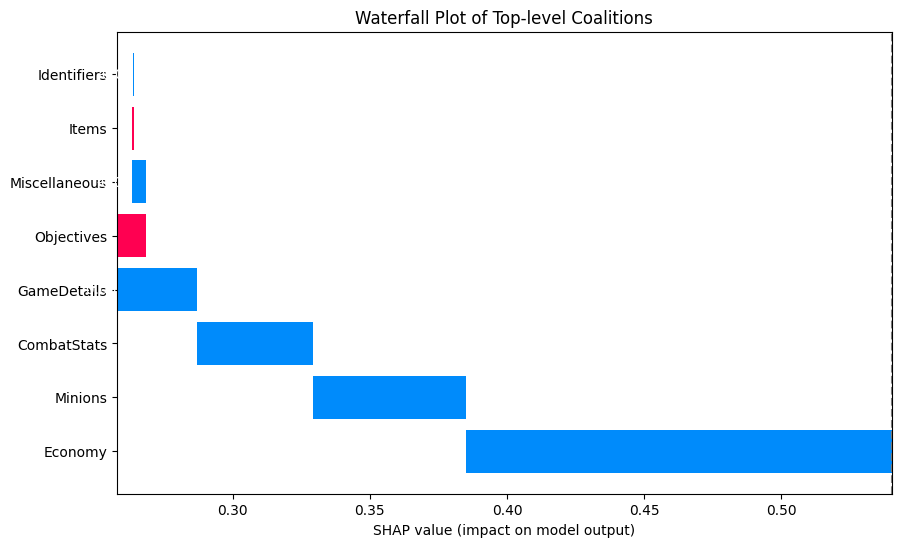

In [81]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import lab2rgb, lch2lab


# Convert LCH to RGB
def lch2rgb(x):
    return lab2rgb(lch2lab([[x]]))[0][0]


blue_lch = [54.0, 70.0, 4.6588]
red_lch = [54.0, 90.0, 0.35470565 + 2 * np.pi]

blue_rgb = lch2rgb(blue_lch)
red_rgb = lch2rgb(red_lch)

# Use the actual SHAP values and base value from winter_values
shap_values = winter_values.values[0]  # Flatten the shape [1, 69] to [69]
base_value = winter_values.base_values[0]  # Get the base value

# Partition hierarchyL
partition_hierarchy = {
    "Identifiers": ["id", "matchid", "player", "gameid", "platformid", "version"],
    "GameDetails": [
        "championid",
        "ss1",
        "ss2",
        "role",
        "position",
        "queueid",
        "seasonid",
        "duration",
        "creation",
    ],
    "Items": ["item1", "item2", "item3", "item4", "item5", "item6", "trinket"],
    "CombatStats": {
        "Kills": [
            "Kills per min.",
            "largestkillingspree",
            "largestmultikill",
            "Killing sprees per min.",
            "Double kills per min.",
            "Triple kills per min.",
            "Quadra kills per min.",
            "Penta kills per min.",
            "Legendary kills per min.",
        ],
        "DamageDealt": [
            "Total damage dealt per min.",
            "Magic damage dealt per min.",
            "Physical damage dealt per min.",
            "True damage dealt per min.",
            "largestcrit",
        ],
        "DamageToChampions": [
            "Total damage to champions per min.",
            "Magic damage to champions per min.",
            "Physical damage to champions per min.",
            "True damage to champions per min.",
        ],
        "Healing": ["Total healing per min.", "Total units healed per min."],
        "DamageTaken": [
            "Total damage taken per min.",
            "Magic damage taken per min.",
            "Physical damage taken per min.",
            "True damage taken per min.",
        ],
        "CrowdControl": [
            "Time spent with crown control per min.",
            "Total crown control time dealt per min.",
        ],
    },
    "Objectives": {
        "DamageToObjectives": ["Damage to objects per min.", "Damage to turrets"],
        "Kills": ["# of turret kills", "# of inhibitor kills"],
    },
    "Economy": {
        "Gold": ["Gold earned per min.", "Gold spent per min."],
        "Wards": [
            "Pink wards bought per min.",
            "Wards bought per min.",
            "Wards placed per min.",
            "wardskilled",
        ],
    },
    "Minions": [
        "Total minions killed per min.",
        "Neutral minions killed per min.",
        "Own jungle kills per min.",
        "Enemy jungle kills per min.",
    ],
    "Miscellaneous": [
        "Longest time living as % of game",
        "visionscore",
        "champlvl",
        "firstblood",
        "dmgselfmit",
    ],
}


# Flatten the hierarchy and map feature names to SHAP value indices
def flatten_hierarchy(hierarchy, prefix=""):
    flat_dict = {}
    for key, value in hierarchy.items():
        if isinstance(value, dict):
            flat_dict.update(flatten_hierarchy(value, prefix=prefix + key + "_"))
        else:
            for v in value:
                flat_dict[prefix + v] = v
    return flat_dict


flat_hierarchy = flatten_hierarchy(partition_hierarchy)

# Map feature names to indices in the SHAP values array
feature_names = list(flat_hierarchy.values())

feature_indices = {feature: idx for idx, feature in enumerate(feature_names)}

# Aggregate SHAP values by top-level coalitions
aggregated_shap_values = {key: 0 for key in partition_hierarchy.keys()}

for coalition, features in partition_hierarchy.items():
    if isinstance(features, dict):
        for sub_coalition, sub_features in features.items():
            for feature in sub_features:
                if feature in feature_indices:
                    idx = feature_indices[feature]
                    aggregated_shap_values[coalition] += shap_values[idx]
    else:
        for feature in features:
            if feature in feature_indices:
                idx = feature_indices[feature]
                aggregated_shap_values[coalition] += shap_values[idx]

# Prepare data for the waterfall plot
coalitions = list(aggregated_shap_values.keys())
values = list(aggregated_shap_values.values())

# Sort by absolute SHAP value
sorted_indices = np.argsort(np.abs(values))[::-1]
coalitions = np.array(coalitions)[sorted_indices]
values = np.array(values)[sorted_indices]


# Waterfall plot
def waterfall_plot(base_value, shap_values, feature_names, max_display=10):
    plt.figure(figsize=(10, 6))

    # Start from the base value
    cumulative = base_value

    # Positions and colors for bars
    positions = []
    colors = []

    for value in shap_values:
        cumulative += value
        positions.append(cumulative)
        colors.append(red_rgb if value > 0 else blue_rgb)

    pos_inds = np.arange(len(shap_values))

    plt.barh(
        pos_inds,
        shap_values,
        left=np.array(positions) - np.array(shap_values),
        color=colors,
    )

    plt.axvline(base_value, color="grey", linestyle="--")
    plt.yticks(range(len(shap_values)), feature_names)
    plt.xlabel("SHAP value (impact on model output)")
    plt.title("Waterfall Plot of Top-level Coalitions")

    for i in range(len(shap_values)):
        plt.text(
            positions[i],
            i,
            f"{shap_values[i]:.2f}",
            va="center",
            ha="right" if shap_values[i] < 0 else "left",
            color="white",
        )

    plt.show()


# Plot the waterfall chart
waterfall_plot(base_value, values, coalitions, max_display=10)

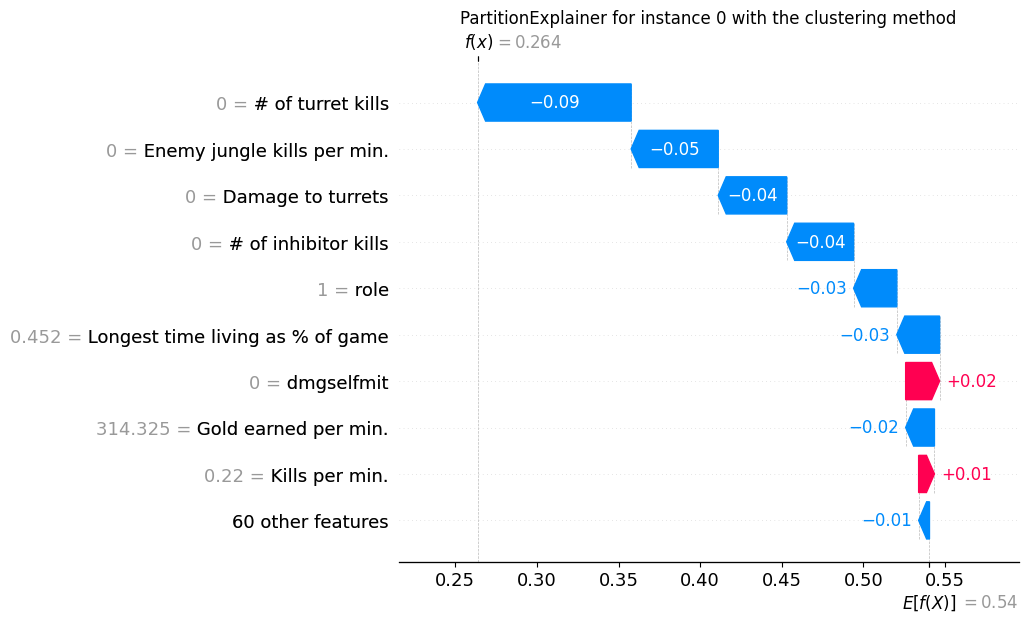

In [82]:
fig, ax = plt.subplots()
shap.plots.waterfall(winter_values[0], show=False)
plt.title("PartitionExplainer for instance 0 with the clustering method")
plt.show()

In [ ]:
partition_explainer = shap.PartitionExplainer(
    predict, partition_masker, partition_tree=partition_tree
)
start_time = time.time()
winter_values = partition_explainer(Xv.iloc[:20, :])
custom_partition_time = time.time() - start_time
print(custom_partition_time)

PartitionExplainer explainer:  30%|███       | 6/20 [45:03<1:52:58, 484.17s/it]

In [ ]:
shap.force_plot(winter_values.base_values, winter_values.values, Xv.iloc[:20, :])

In [ ]:
shap_values[:10]

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[:20], Xv.iloc[:20, :])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np  # Make sure to import numpy


def lch2rgb(x):
    return lab2rgb(lch2lab([[x]]))[0][0]


blue_lch = [54.0, 70.0, 4.6588]
red_lch = [54.0, 90.0, 0.35470565 + 2 * np.pi]

plt.figure(figsize=(15, 8))

# Plot the SHAP values with enhanced visibility
plt.plot(
    winter_values.values, linestyle="-", linewidth=2, label="Exact SHAP", color="green"
)
plt.plot(
    shap_values[:20],
    linestyle="-",
    linewidth=2,
    label="Tree SHAP",
    color=lch2rgb(red_lch),
    alpha=1,
)


# Adding title and labels with increased font sizes
plt.title("Comparison of SHAP Values", fontsize=20, fontweight="bold")
plt.xlabel("Feature Index", fontsize=16)
plt.ylabel("SHAP Value", fontsize=16)

# Customizing the legend for better readability
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(
    by_label.values(),
    by_label.keys(),
    loc="upper right",
    fontsize=12,
    frameon=True,
    fancybox=True,
    shadow=True,
    borderpad=1,
)

# Adding a grid for better readability
plt.grid(True, which="both", linestyle="--", linewidth=0.5, alpha=0.7)

# Adding a white background
plt.gca().set_facecolor("white")

# Adding a horizontal line at y=0 for reference
plt.axhline(0, color="grey", linestyle="--", linewidth=1)

plt.savefig(
    r"C:\Users\azabe\Documents\GitHub\Winter_values\winter_values\reports\approximation.png"
)

# Display the plot
plt.show()

In [ ]:
print("computation time for the custom partition", custom_partition_time / 60)

In [ ]:
partition_masker = shap.maskers.Partition(Xt)
clustering_explainer = shap.PartitionExplainer(
    predict, partition_masker
)  # , max_evals = 100)

clustering_winter_values = clustering_explainer(instance)
print(clustering_explainer.last_eval_count)

In [ ]:
shap_values0 = explainer(instance)

In [ ]:
len(X.columns)

In [ ]:
len(clustering_explainer._clustering)

In [ ]:
plt.figure(figsize=(15, 6))
sp.cluster.hierarchy.dendrogram(clustering_explainer._clustering, labels=X.columns)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("feature")
plt.ylabel("distance")
plt.show()

In [ ]:
def create_partition_hierarchy(linkage_matrix, columns):
    def build_hierarchy(node, linkage_matrix, columns):
        if node < len(columns):
            return {columns[node]: columns[node]}
        else:
            left_child = int(linkage_matrix[node - len(columns), 0])
            right_child = int(linkage_matrix[node - len(columns), 1])
            left_subtree = build_hierarchy(left_child, linkage_matrix, columns)
            right_subtree = build_hierarchy(right_child, linkage_matrix, columns)
            return {f"cluster_{node}": {**left_subtree, **right_subtree}}

    root_node = len(linkage_matrix) + len(columns) - 1
    hierarchy = build_hierarchy(root_node, linkage_matrix, columns)
    return hierarchy[f"cluster_{root_node}"]

In [ ]:
clustering_tree = create_partition_hierarchy(
    clustering_explainer._clustering, X.columns
)

In [ ]:
clustering_tree

In [ ]:
fig, ax = plt.subplots()
shap.plots.waterfall(shap_values0[0], show=False)
plt.title("PartitionExplainer for instance 0 with the clustering method")
plt.show()

In [ ]:
fig, ax = plt.subplots()
shap.plots.waterfall(clustering_winter_values[0], show=False)
plt.title("PartitionExplainer for instance 0 with the clustering method")
plt.show()

In [ ]:
fig, ax = plt.subplots()
shap.plots.waterfall(winter_values[0], show=False)
plt.title("PartitionExplainer for instance 0 with the clustering method")
plt.show()

### Explain a single player's chances of winning a particular match

SHAP values sum to the difference between the expected output of the model and the current output for the current player. Note that for the Tree SHAP implementation the margin output of the model is explained, not the transformed output (such as a probability for logistic regression). This means that the units of the SHAP values for this model are log odds ratios. Large positive values mean a player is likely to win, while large negative values mean they are likely to lose.

In [ ]:
shap.force_plot(explainer.expected_value, shap_values[4:5, :], Xv.iloc[0, :])

In [ ]:
xs = np.linspace(-4, 4, 100)
pl.xlabel("Log odds of winning")
pl.ylabel("Probability of winning")
pl.title("How changes in log odds convert to probability of winning")
pl.plot(xs, 1 / (1 + np.exp(-xs)))
pl.show()

### Summarize the impact of all features over the entire dataset

A SHAP value for a feature of a specific prediction represents how much the model prediction changes when we observe that feature. In the summary plot below we plot all the SHAP values for a single feature (such as `goldearned`) in a row, where the x-axis is the SHAP value (which for this model is in units of log odds of winning). By doing this for all features, we see which features drive the model's prediction a lot (such as `goldearned`), and which only effect the prediction a little (such as `kills`). Note that when points don't fit together on the line they pile up vertically to show density. Each dot is also colored by the value of that feature from high to low.

In [ ]:
shap.summary_plot(shap_values, Xv)

## Examine how changes in a feature change the model's prediction

The XGBoost model we trained above is very complicated, but by plotting the SHAP value for a feature against the actual value of the feature for all players we can see how changes in the feature's value effect the model's output. Note that these plots are very similar to standard partial dependence plots, but they provide the added advantage of displaying how much context matters for a feature (or in other words how much interaction terms matter). How much interaction terms effect the importance of a feature is captured by the vertical dispersion of the data points. For example earning only 100 gold/min during a game may lower your log odds of winning by 10 for some players or only 3 for others. Why is this? Because other features of these players effect how much earning gold matters for winning the game. Note that the vertical spread narrows once you earn at least 500 gold/min, meaning the context of other features matters less for high gold earners than low gold earners. We color the datapoints with another feature that most explains the interaction effect variance. For example earning less gold is less bad if you have not died very much, but it is really bad if you also die a lot.

The y-axis in the plots below represents the SHAP value for that feature, so -4 means observing that feature lowers your log odds of winning by 4, while a value of +2 means observing that feature raises your log odds of winning by 2.

Note that these plot just explain how the XGBoost model works, not nessecarily how reality works. Since the XGBoost model is trained from observational data, it is not nessecarily a causal model, and so just because changing a factor makes the model's prediction of winning go up, does not always mean it will raise your actual chances.

In [ ]:
shap.dependence_plot(
    "Gold earned per min.", shap_values, Xv, interaction_index="Deaths per min."
)

In [ ]:
# sort the features indexes by their importance in the model
# (sum of SHAP value magnitudes over the validation dataset)
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

# make SHAP plots of the three most important features
for i in range(20):
    shap.dependence_plot(top_inds[i], shap_values, Xv)